## Engenharia de Sistemas de Software Inteligentes

## Modelo para predição de Alzheimer

In [29]:
# configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

# Imports necessários
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from pickle import dump
from pickle import load

## Carga do Dataset

In [13]:
# Informa a URL de importação do dataset
url = "https://github.com/tostavio/datasets/blob/main/alzheimers_disease_data.csv?raw=true"

# Lê o arquivo
dataset = pd.read_csv(url, delimiter=',')

# Eu analisei a base e já sei que não há dados duplicados
# mas achei interessante mostrar essa preparação dos dados

# Verifica se existem valores duplicados na coluna PatientID
duplicados = dataset[dataset.duplicated(subset='PatientID')]

# Exibe os dados duplicados se existirem
print(duplicados)

# Remove linhas duplicadas com base na coluna PatientID,
# mantendo a primeira ocorrência
dataset = dataset.drop_duplicates(subset='PatientID', keep='first')

# Remove a primeira coluna (patientId) e a última coluna (doctorCharge)
# Essas colunas são irrelevantes para a predição dos dados
dataset = dataset.drop(dataset.columns[[0, -1]], axis=1)

# Mostra as primeiras linhas do dataset
dataset.head()

Empty DataFrame
Columns: [PatientID, Age, Gender, Ethnicity, EducationLevel, BMI, Smoking, AlcoholConsumption, PhysicalActivity, DietQuality, SleepQuality, FamilyHistoryAlzheimers, CardiovascularDisease, Diabetes, Depression, HeadInjury, Hypertension, SystolicBP, DiastolicBP, CholesterolTotal, CholesterolLDL, CholesterolHDL, CholesterolTriglycerides, MMSE, FunctionalAssessment, MemoryComplaints, BehavioralProblems, ADL, Confusion, Disorientation, PersonalityChanges, DifficultyCompletingTasks, Forgetfulness, Diagnosis, DoctorInCharge]
Index: []

[0 rows x 35 columns]


,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,SleepQuality,...,FunctionalAssessment,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Diagnosis
0,73,0,0,2,22.927749,0,13.297218,6.327112,1.347214,9.025679,...,6.518877,0,0,1.725883,0,0,0,1,0,0
1,89,0,0,0,26.827681,0,4.542524,7.619885,0.518767,7.151293,...,7.118696,0,0,2.592424,0,0,0,0,1,0
2,73,0,3,1,17.795882,0,19.555085,7.844988,1.826335,9.673574,...,5.895077,0,0,7.119548,0,1,0,1,0,0
3,74,1,0,1,33.800817,1,12.209266,8.428001,7.435604,8.392554,...,8.965106,0,1,6.481226,0,0,0,0,0,0
4,89,0,0,0,20.716974,0,18.454356,6.310461,0.795498,5.597238,...,6.045039,0,0,0.014691,0,0,1,1,0,0


## Separação em conjunto de treino e conjunto de teste com holdout

In [14]:
test_size = 0.20 # tamanho do conjunto de teste
seed = 9 # semente aleatória

# Separação em conjuntos de treino e teste
array = dataset.values
X = array[:, :-1]  # Todas as colunas exceto a última (Diagnosis)
y = array[:, -1]   # A última coluna (Diagnosis)

X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=test_size, shuffle=True, random_state=seed, stratify=y) # holdout com estratificação

# Mostrando as dimensões dos conjuntos
print(f"Tamanho do conjunto de treino: {X_train.shape}")
print(f"Tamanho do conjunto de teste: {X_test.shape}")

# Parâmetros e partições da validação cruzada
scoring = 'accuracy'
num_particoes = 15
kfold = StratifiedKFold(n_splits=num_particoes, shuffle=True, random_state=seed) # validação cruzada com estratificação

Tamanho do conjunto de treino: (1719, 32)
Tamanho do conjunto de teste: (430, 32)


## Modelagem e Inferência

### Criação e avaliação de modelos: dados padronizados e normalizados (sem otimização)

KNN-orig: 0.570 (0.035)
CART-orig: 0.902 (0.025)
NB-orig: 0.800 (0.045)
SVM-orig: 0.646 (0.003)
KNN-padr: 0.743 (0.029)
CART-padr: 0.899 (0.028)
NB-padr: 0.800 (0.045)
SVM-padr: 0.838 (0.038)
KNN-norm: 0.705 (0.042)
CART-norm: 0.901 (0.032)
NB-norm: 0.800 (0.045)
SVM-norm: 0.835 (0.037)


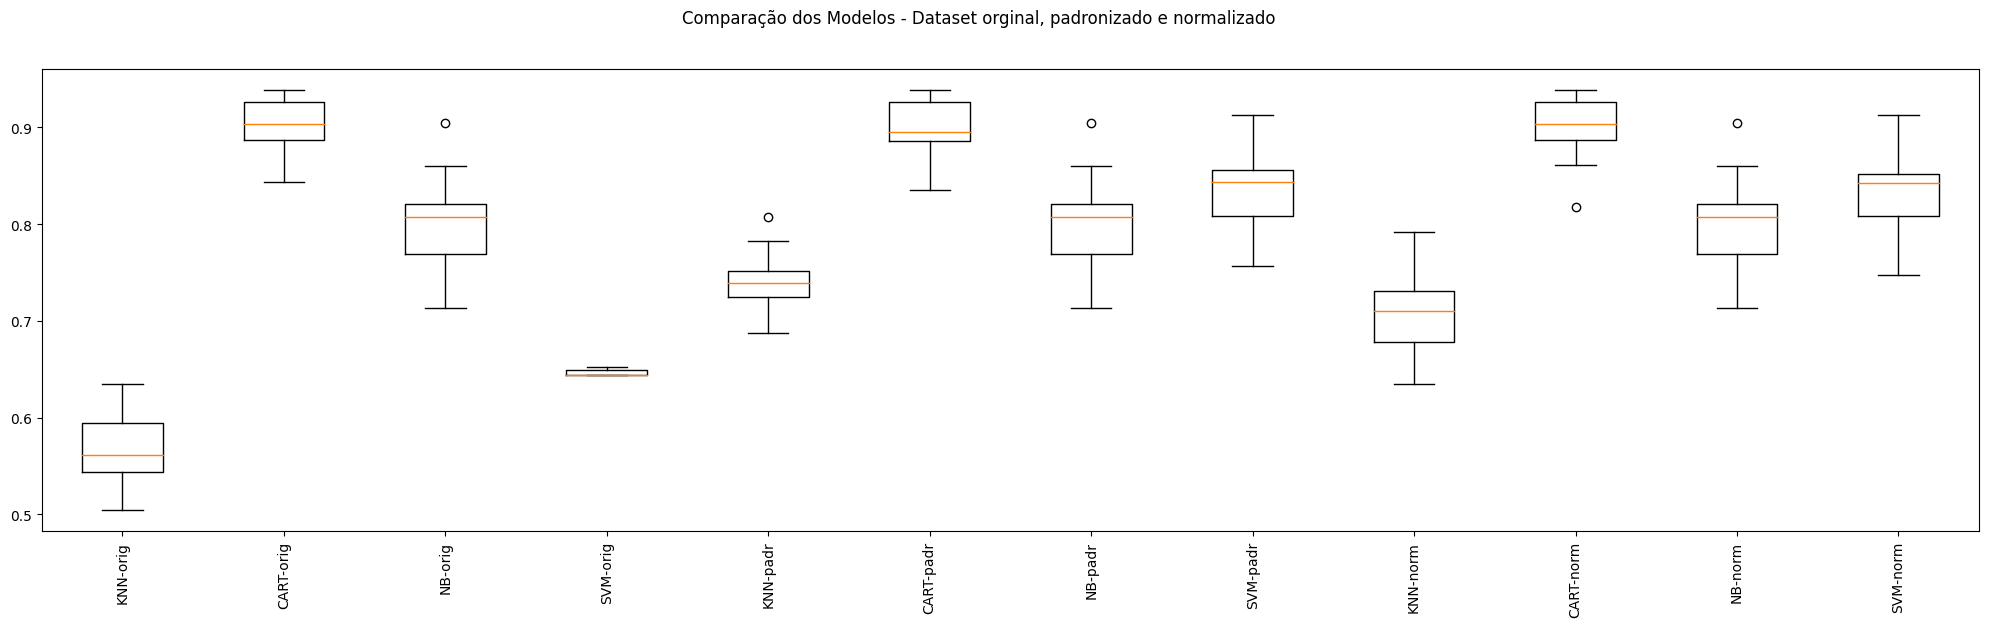

In [15]:
np.random.seed(9) # definindo uma semente global para este bloco

# Listas para armazenar os armazenar os pipelines e os resultados para todas as visões do dataset
pipelines = []
results = []
names = []


# Criando os elementos do pipeline

# Algoritmos que serão utilizados
knn = ('KNN', KNeighborsClassifier())
cart = ('CART', DecisionTreeClassifier())
naive_bayes = ('NB', GaussianNB())
svm = ('SVM', SVC())

# Transformações que serão utilizadas
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())


# Montando os pipelines

# Dataset original
pipelines.append(('KNN-orig', Pipeline([knn])))
pipelines.append(('CART-orig', Pipeline([cart])))
pipelines.append(('NB-orig', Pipeline([naive_bayes])))
pipelines.append(('SVM-orig', Pipeline([svm])))

# Dataset Padronizado
pipelines.append(('KNN-padr', Pipeline([standard_scaler, knn])))
pipelines.append(('CART-padr', Pipeline([standard_scaler, cart])))
pipelines.append(('NB-padr', Pipeline([standard_scaler, naive_bayes])))
pipelines.append(('SVM-padr', Pipeline([standard_scaler, svm])))

# Dataset Normalizado
pipelines.append(('KNN-norm', Pipeline([min_max_scaler, knn])))
pipelines.append(('CART-norm', Pipeline([min_max_scaler, cart])))
pipelines.append(('NB-norm', Pipeline([min_max_scaler, naive_bayes])))
pipelines.append(('SVM-norm', Pipeline([min_max_scaler, svm])))

# Executando os pipelines
for name, model in pipelines:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %.3f (%.3f)" % (name, cv_results.mean(), cv_results.std()) # formatando para 3 casas decimais
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(25,6))
fig.suptitle('Comparação dos Modelos - Dataset orginal, padronizado e normalizado')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names, rotation=90)
plt.show()

**Até o momento, o CART tem se mostrado muito promissor. Vou conduzir um teste com Hiperparâmetros para ver se o desempenho do CART se mantém.**


### Preparando os parametros para a otimização de Hiperparâmetros

In [16]:
np.random.seed(9) # definindo uma semente global para este bloco

# Hiperparâmetros para otimização
param_grid_knn = {
'KNN__n_neighbors': [1,3,5,7,9,11,13,15,17,19,21],
    'KNN__metric': ["euclidean", "manhattan", "minkowski"],
}

param_grid_cart = {
    'CART__max_depth': [3, 5, 10, None],
    'CART__min_samples_split': [2, 5, 10],
    'CART__min_samples_leaf': [1, 2, 4]
}

param_grid_nb = {
    'NB__var_smoothing': [1e-09, 1e-08, 1e-07]
}

param_grid_svm = {
    'SVM__C': [0.1, 1, 10, 100],
    'SVM__kernel': ['linear', 'rbf'],
    'SVM__gamma': ['scale', 'auto']
}

# Algoritmos que serão utilizados
knn = ('KNN', KNeighborsClassifier())
cart = ('CART', DecisionTreeClassifier())
naive_bayes = ('NB', GaussianNB())
svm = ('SVM', SVC())

# Transformações que serão utilizadas
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

### Otimização dos hiperparâmetros

Resultados com otimização de hiperparâmetros:
KNN-orig - Melhor Acurácia: 0.650
Melhores Parâmetros: {'KNN__n_neighbors': 17, 'KNN__metric': 'manhattan'}
CART-orig - Melhor Acurácia: 0.947
Melhores Parâmetros: {'CART__min_samples_split': 2, 'CART__min_samples_leaf': 4, 'CART__max_depth': 5}
NB-orig - Melhor Acurácia: 0.801
Melhores Parâmetros: {'NB__var_smoothing': 1e-07}
SVM-orig - Melhor Acurácia: 0.841
Melhores Parâmetros: {'SVM__kernel': 'linear', 'SVM__gamma': 'auto', 'SVM__C': 0.1}
KNN-padr - Melhor Acurácia: 0.758
Melhores Parâmetros: {'KNN__n_neighbors': 17, 'KNN__metric': 'manhattan'}
CART-padr - Melhor Acurácia: 0.947
Melhores Parâmetros: {'CART__min_samples_split': 2, 'CART__min_samples_leaf': 4, 'CART__max_depth': 5}
NB-padr - Melhor Acurácia: 0.800
Melhores Parâmetros: {'NB__var_smoothing': 1e-09}
SVM-padr - Melhor Acurácia: 0.838
Melhores Parâmetros: {'SVM__kernel': 'rbf', 'SVM__gamma': 'auto', 'SVM__C': 1}
KNN-norm - Melhor Acurácia: 0.748
Melhores Parâmetros: {'KNN__n_n

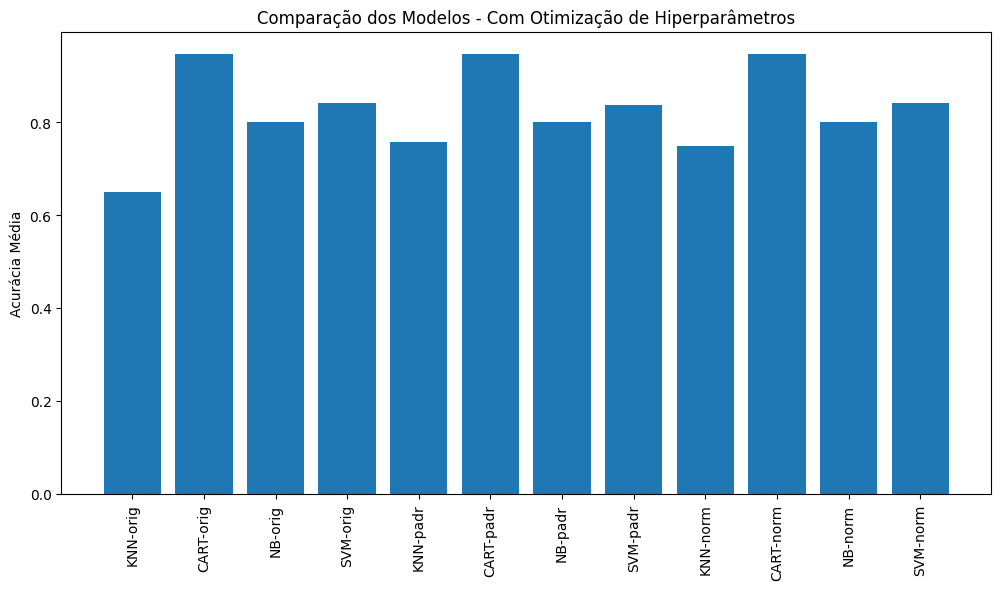

In [17]:
# Criando os pipelines com Hiperparâmetros para os dados originais,
# padronizados e normalizados
pipelines = [
     # KNN com dados originais
    ('KNN-orig',
     Pipeline(steps=[
         ('KNN', KNeighborsClassifier())
     ]),
     param_grid_knn),

    # Árvore de Decisão com dados originais
    ('CART-orig',
     Pipeline(steps=[
         ('CART', DecisionTreeClassifier())
     ]),
     param_grid_cart),

    # Naive Bayes com com dados originais
    ('NB-orig',
     Pipeline(steps=[
         ('NB', GaussianNB())
     ]),
     param_grid_nb),

    # SVM com padronização com dados originais
    ('SVM-orig',
     Pipeline(steps=[
         ('SVM', SVC())
     ]),
     param_grid_svm),

    # KNN com padronização
    ('KNN-padr',
     Pipeline(steps=[
         ('StandardScaler', StandardScaler()),
         ('KNN', KNeighborsClassifier())
     ]),
     param_grid_knn),

    # Árvore de Decisão com padronização
    ('CART-padr',
     Pipeline(steps=[
         ('StandardScaler', StandardScaler()),
         ('CART', DecisionTreeClassifier())
     ]),
     param_grid_cart),

    # Naive Bayes com padronização
    ('NB-padr',
     Pipeline(steps=[
         ('StandardScaler', StandardScaler()),
         ('NB', GaussianNB())
     ]),
     param_grid_nb),

    # SVM com padronização
    ('SVM-padr',
     Pipeline(steps=[
         ('StandardScaler', StandardScaler()),
         ('SVM', SVC())
     ]),
     param_grid_svm),

    # KNN com normalização
    ('KNN-norm',
     Pipeline(steps=[
         ('MinMaxScaler', MinMaxScaler()),
         ('KNN', KNeighborsClassifier())
     ]),
     param_grid_knn),

    # Árvore de Decisão com normalização
    ('CART-norm',
     Pipeline(steps=[
         ('MinMaxScaler', MinMaxScaler()),
         ('CART', DecisionTreeClassifier())
     ]),
     param_grid_cart),

    # Naive Bayes com normalização
    ('NB-norm',
     Pipeline(steps=[
         ('MinMaxScaler', MinMaxScaler()),
         ('NB', GaussianNB())
     ]),
     param_grid_nb),

    # SVM com normalização
    ('SVM-norm',
     Pipeline(steps=[
         ('MinMaxScaler', MinMaxScaler()),
         ('SVM', SVC())
     ]),
     param_grid_svm)
]

# limpando as variaveis
results = []
names = []

# Como a otimização acaba demorando muito para executar, eu optei por utilizar
# o RandomizedSearchCV, para não precisar percorrer toda o dataset e optei
# por usar um gráfico de barras, já que ao invés de obter uma lista de valores
# para cada modelo, eu irei obter apenas o best_score de cada modelo.
# Sendo assim, não posso usar o boxplot, pois preciso de uma lista de valores
# para cada rótulo.

# Resultados com otimização de hiperparâmetros:
print("Resultados com otimização de hiperparâmetros:")
for name, model, param_grid in pipelines:
    grid = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grid,
        n_iter=5,  # Número de combinações aleatórias a testar
        scoring='accuracy',
        cv=kfold,
        random_state=9
    )
    grid.fit(X_train, y_train)

    # Captura o melhor resultado de validação cruzada (a média)
    best_accuracy = grid.best_score_
    results.append(best_accuracy)
    names.append(name)
    print(f"{name} - Melhor Acurácia: {best_accuracy:.3f}")
    print(f"Melhores Parâmetros: {grid.best_params_}")

# Gráfico de Barras para comparar as acurácias médias
fig = plt.figure(figsize=(12, 6))
plt.bar(names, results)
plt.xticks(rotation=90)
plt.ylabel("Acurácia Média")
plt.title("Comparação dos Modelos - Com Otimização de Hiperparâmetros")
plt.show()

**Parece que o desempenho do CART se manteve. Agora quero analisar melhor como ele se comporta com um teste na base inteira, mas olhando para hiperparâmetros, padronização e normalização dos dados.**

### Preparando os parametros para a otimização de Hiperparâmetros do modelo CART

In [18]:
np.random.seed(9) # definindo uma semente global para este bloco
# Hiperparâmetros para otimização

param_grid_cart = {
    'CART__max_depth': [3, 5, 10, None],
    'CART__min_samples_split': [2, 5, 10],
    'CART__min_samples_leaf': [1, 2, 4]
}

# Algoritmos que serão utilizados
cart = ('CART', DecisionTreeClassifier())

# Transformações que serão utilizadas
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

###Otimização dos hiperparâmetros modelo CART

Resultados com otimização de hiperparâmetros:
CART-orig - Melhor Acurácia: 0.948
Melhores Parâmetros: {'CART__max_depth': 5, 'CART__min_samples_leaf': 4, 'CART__min_samples_split': 5}
CART-padr - Melhor Acurácia: 0.947
Melhores Parâmetros: {'CART__max_depth': 5, 'CART__min_samples_leaf': 4, 'CART__min_samples_split': 10}
CART-norm - Melhor Acurácia: 0.948
Melhores Parâmetros: {'CART__max_depth': 5, 'CART__min_samples_leaf': 4, 'CART__min_samples_split': 5}


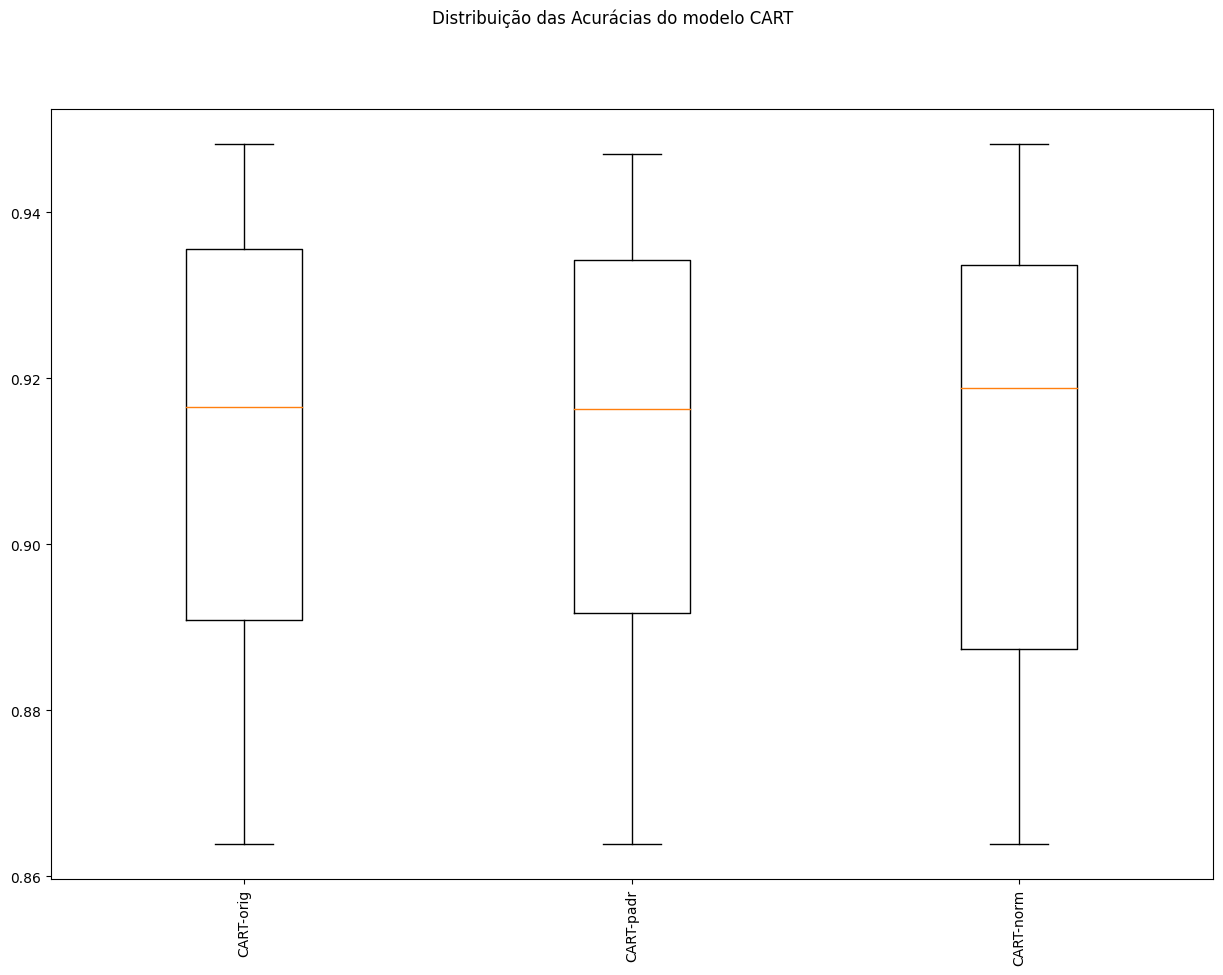

In [19]:
# Criando os pipelines com Hiperparâmetros para os dados originais,
# padronizados e normalizados
pipelines = [
    # Árvore de Decisão com dados originais
    ('CART-orig',
     Pipeline(steps=[
         ('CART', DecisionTreeClassifier())
     ]),
     param_grid_cart),

    # Árvore de Decisão com padronização
    ('CART-padr',
     Pipeline(steps=[
         ('StandardScaler', StandardScaler()),
         ('CART', DecisionTreeClassifier())
     ]),
     param_grid_cart),

    # Árvore de Decisão com normalização
    ('CART-norm',
     Pipeline(steps=[
         ('MinMaxScaler', MinMaxScaler()),
         ('CART', DecisionTreeClassifier())
     ]),
     param_grid_cart),
]

# limpando as variaveis
results = []
names = []

# Resultados com otimização de hiperparâmetros:
print("Resultados com otimização de hiperparâmetros:")
for name, model, param_grid in pipelines:
    grid = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring='accuracy',
        cv=kfold,
    )
    grid.fit(X_train, y_train)

    # Exibe o melhor resultado
    print(f"{name} - Melhor Acurácia: {grid.best_score_:.3f}")
    print(f"Melhores Parâmetros: {grid.best_params_}")

    # Captura todas as acurácias para cada combinação de hiperparâmetros
    all_accuracies = grid.cv_results_['mean_test_score']

    # Armazena todas as acurácias para o modelo atual
    results.append(all_accuracies)  # Cada item é uma lista de acurácias para um modelo
    names.append(name)  # Adiciona o nome do modelo uma única vez

# Gráfico de Boxplot para comparar a distribuição das acurácias de cada modelo
fig = plt.figure(figsize=(15,10))
fig.suptitle('Distribuição das Acurácias do modelo CART')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names, rotation=90)
plt.show()

**Após analisar todos os modelos sem padronização, normalização e otimização e analisar também com padronização, normalização e otimização, ficou claro que o modelo CART é o que desempenha melhor para esse dataset, portanto irei seguir com ele.**

**Embora a média tenha sido algo perto de 0.95 para os 3, o CART com dados normalizados mostrou uma linha ligeiramente mais próxima dos 75%. Portanto, irei seguir com o CART + dados normalizados.**

## Finalização do Modelo

In [20]:
## Finalização do Modelo

# Avaliação do modelo com o conjunto de testes

# Preparação do modelo
scaler = MinMaxScaler().fit(X_train)  # ajuste do scaler com o conjunto de treino (normalização)
rescaledX = scaler.transform(X_train)  # aplicação da normalização no conjunto de treino

# Inicializa o modelo CART com os melhores hiperparâmetros encontrados
model = DecisionTreeClassifier(max_depth=5, min_samples_leaf=2, min_samples_split=5)
model.fit(rescaledX, y_train)

# Estimativa da acurácia no conjunto de teste
rescaledTestX = scaler.transform(X_test)  # aplicação da normalização no conjunto de teste
predictions = model.predict(rescaledTestX)
print(f"Acurácia no conjunto de teste: {accuracy_score(y_test, predictions):.3f}")

Acurácia no conjunto de teste: 0.940


In [21]:
# Preparação do modelo com TODO o dataset
scaler = MinMaxScaler().fit(X)  # ajuste do scaler com TODO o dataset (normalização)
rescaledX = scaler.transform(X)  # aplicação da normalização com TODO o dataset
model.fit(rescaledX, y)  # Treinando o modelo com todos os dados

DecisionTreeClassifier(max_depth=5, min_samples_leaf=2, min_samples_split=5)

## Simulando a aplicação do modelo em dados não vistos

In [23]:
## Simulando a aplicação do modelo em dados não vistos

# Simulando novos pacientes com base em todas as colunas relevantes do dataset

data = {
    'Age':  [70, 80, 85],                    # Idade
    'Gender': [0, 1, 0],                     # Gênero
    'Ethnicity': [1, 2, 3],                  # Etnia
    'EducationLevel': [2, 1, 3],             # Nível educacional
    'BMI': [23.5, 29.4, 20.1],               # Índice de Massa Corporal
    'Smoking': [0, 1, 0],                    # Fumante
    'AlcoholConsumption': [5.0, 2.0, 10.0],  # Consumo de álcool
    'PhysicalActivity': [7.5, 5.0, 6.0],     # Atividade física
    'DietQuality': [3.0, 2.0, 4.0],          # Qualidade da dieta
    'SleepQuality': [7.0, 5.0, 6.0],         # Qualidade do sono
    'FamilyHistoryAlzheimers': [1, 0, 1],    # Histórico familiar de Alzheimer
    'CardiovascularDisease': [1, 0, 0],      # Doença cardiovascular
    'Diabetes': [0, 1, 0],                   # Diabetes
    'Depression': [1, 0, 1],                 # Depressão
    'HeadInjury': [0, 1, 0],                 # Lesão na cabeça
    'Hypertension': [1, 1, 0],               # Hipertensão
    'SystolicBP': [120, 140, 130],           # Pressão arterial sistólica
    'DiastolicBP': [80, 90, 85],             # Pressão arterial diastólica
    'CholesterolTotal': [200, 250, 210],     # Colesterol total
    'CholesterolLDL': [100, 150, 120],       # Colesterol LDL
    'CholesterolHDL': [60, 55, 65],          # Colesterol HDL
    'CholesterolTriglycerides': [150, 180, 160], # Triglicerídeos
    'MMSE': [28, 22, 18],                    # Mini Mental State Examination
    'FunctionalAssessment': [2.0, 3.5, 1.5], # Avaliação funcional
    'MemoryComplaints': [1, 1, 0],           # Queixas de memória
    'BehavioralProblems': [0, 1, 1],         # Problemas comportamentais
    'ADL': [5.0, 6.0, 4.0],                  # Atividades de vida diária
    'Confusion': [0, 1, 1],                  # Confusão
    'Disorientation': [0, 1, 1],             # Desorientação
    'PersonalityChanges': [1, 0, 1],         # Mudanças de personalidade
    'DifficultyCompletingTasks': [1, 1, 0],  # Dificuldade em completar tarefas
    'Forgetfulness': [1, 1, 0],              # Esquecimento
}

# Criação do DataFrame com os novos dados
atributos = ['Age', 'Gender', 'Ethnicity', 'EducationLevel', 'BMI', 'Smoking', 'AlcoholConsumption',
             'PhysicalActivity', 'DietQuality', 'SleepQuality', 'FamilyHistoryAlzheimers',
             'CardiovascularDisease', 'Diabetes', 'Depression', 'HeadInjury', 'Hypertension',
             'SystolicBP', 'DiastolicBP', 'CholesterolTotal', 'CholesterolLDL', 'CholesterolHDL',
             'CholesterolTriglycerides', 'MMSE', 'FunctionalAssessment', 'MemoryComplaints',
             'BehavioralProblems', 'ADL', 'Confusion', 'Disorientation', 'PersonalityChanges',
             'DifficultyCompletingTasks', 'Forgetfulness']

entrada = pd.DataFrame(data, columns=atributos)

# Normalização nos novos dados usando o mesmo scaler ajustado com TODO o dataset
rescaledEntradaX = scaler.transform(entrada)
print("Dados normalizados de entrada:")
print(rescaledEntradaX)

Dados normalizados de entrada:
[[0.33333333 0.         0.33333333 0.66666667 0.3398646  0.
  0.25005875 0.75085378 0.29939203 0.49979416 1.         1.
  0.         1.         0.         1.         0.33707865 0.33898305
  0.3329331  0.33238259 0.50010154 0.2849297  0.93358981 0.2000339
  1.         0.         0.49994824 0.         0.         1.
  1.         1.        ]
 [0.66666667 1.         0.66666667 0.33333333 0.57601653 1.
  0.09996337 0.50044845 0.19928152 0.16630584 0.         0.
  1.         0.         1.         1.         0.56179775 0.50847458
  0.66648872 0.66630595 0.43758348 0.37075809 0.73349689 0.35009382
  1.         1.         0.59996365 1.         1.         0.
  1.         1.        ]
 [0.83333333 0.         1.         1.         0.20377705 0.
  0.50021773 0.60061058 0.39950254 0.33305    1.         0.
  0.         1.         0.         0.         0.4494382  0.42372881
  0.39964423 0.46595193 0.5626196  0.31353916 0.60010161 0.15001393
  0.         1.         0.399932

In [24]:
# Predição de classes dos novos pacientes
saidas = model.predict(rescaledEntradaX)
print("Predições para os novos pacientes:")
print(saidas)

Predições para os novos pacientes:
[0. 1. 1.]


## Exportando o modelo com Pickle

In [25]:
# Cria a pipeline com normalização e o modelo de classificação
pipeline = Pipeline(steps=[
    ('scaler', MinMaxScaler()),                     # Etapa de normalização dos dados
    ('model', DecisionTreeClassifier(max_depth=5, min_samples_leaf=2, min_samples_split=5))  # Modelo CART
])

# Treina a pipeline
pipeline.fit(X_train, y_train)

# Avaliação no conjunto de teste (opcional)
y_pred = pipeline.predict(X_test)

# Calcula a acurácia no conjunto de teste
accuracy = accuracy_score(y_test, y_pred)
print(f"Acurácia no conjunto de teste: {accuracy:.3f}")

Acurácia no conjunto de teste: 0.940


In [27]:
# Serializa o pipeline e a acurácia juntas em um dicionário
model_data = {
    'pipeline': pipeline,
    'accuracy': accuracy
}

# Salva o model_data no disco
filename = 'model.pkl'
with open(filename, 'wb') as file:
    dump(model_data, file)  # Aqui, model_data é serializado, não o pipeline sozinho
print("Pipeline do modelo e acurácia salvos com sucesso!")

Pipeline do modelo e acurácia salvos com sucesso!


In [30]:
# Carrega o modelo e a acurácia do disco
with open(filename, 'rb') as f:
    loaded_data = pickle.load(f)
    loaded_pipeline = loaded_data['pipeline']
    loaded_accuracy = loaded_data['accuracy']

# Faz uma avaliação para verificar se o modelo foi carregado corretamente
result = loaded_pipeline.score(X_test, y_test)
print(f"Acurácia carregada: {loaded_accuracy}")
print(f"Acurácia aferida do modelo carregado: {result}")

Acurácia carregada: 0.9395348837209302
Acurácia do modelo carregado: 0.9395348837209302


## Conclusões finais

O modelo de árvore de decisão (CART) foi o mais eficaz entre os algoritmos testados (KNN, Naive Bayes, SVM), apresentando a melhor acurácia tanto nos dados originais quanto após normalização e otimização de hiperparâmetros. A normalização foi especialmente importante para melhorar a performance de outros modelos, mas o CART manteve-se como a opção mais robusta e confiável.

Tive problemas com performance, dado o grande volume de colunas e uma boa amostragem de dados. Porém optei por não reduzir a amostragem para não perder qualidade, ao invés disso, otimizei com randomização quando foi necessário.

Também optei por exportar uma Pipeline que já normaliza e executa a predição, para evitar complicações no backend e não criar acoplamento/divergência de responsabilidade entre o meu back e o modelo.

Além da pipeline, optei por exportar junto a acuracia do meu modelo. Dessa forma, não preciso treina-lo novamente no meu backend.

